Рассчитайте понедельный отвал пользователей для когорт игроков (iOS/Android/органика/неорганика).
Сравните полученные результаты между собой, сделайте выводы.


In [ ]:
#расчет churn_rate sql
churn_rate=pd.read_sql(f'''
with data as

         (SELECT  event_time, user_id, platform, 
            min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
            user_type
            FROM data_viz_1068.project_dataset
            WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp')),
temp_df as(
        SELECT case when user_id>0 then '1' end as  merge,(ROW_NUMBER() OVER())-1 num
        FROM data_viz_1068.project_dataset
        WHERE event_name='FirstLaunchApp'
        LIMIT 61
    )

        SELECT lifetime, 1-cast(users as float)/cast(max as float) as churn_rate, platform,user_type
        FROM
            (SELECT num as lifetime, count(distinct user_id) as users,platform, user_type,
            max(count(distinct user_id)) over (partition by platform,user_type) as max
            FROM
            (SELECT lifetime,num, user_id,platform,user_type
            FROM
                    (SELECT *
                    FROM (SELECT max(extract(day from(date_trunc('week',event_time)-date_trunc('week',date_install))/7)) as lifetime,
                    user_id, platform, user_type, case when user_id>0 then '1' end as  merge
                    FROM data
                    WHERE event_time <=(date_install+INTERVAL '4' MONTH) 
                    GROUP BY 2,3,4
                    ORDER BY 1) as l

                    JOIN temp_df  as i
                    ON l.merge=i.merge) as o
            WHERE lifetime>=num 
            ) as f
            GROUP BY 1,3,4)as w
        ORDER BY 1
''', con=engine)

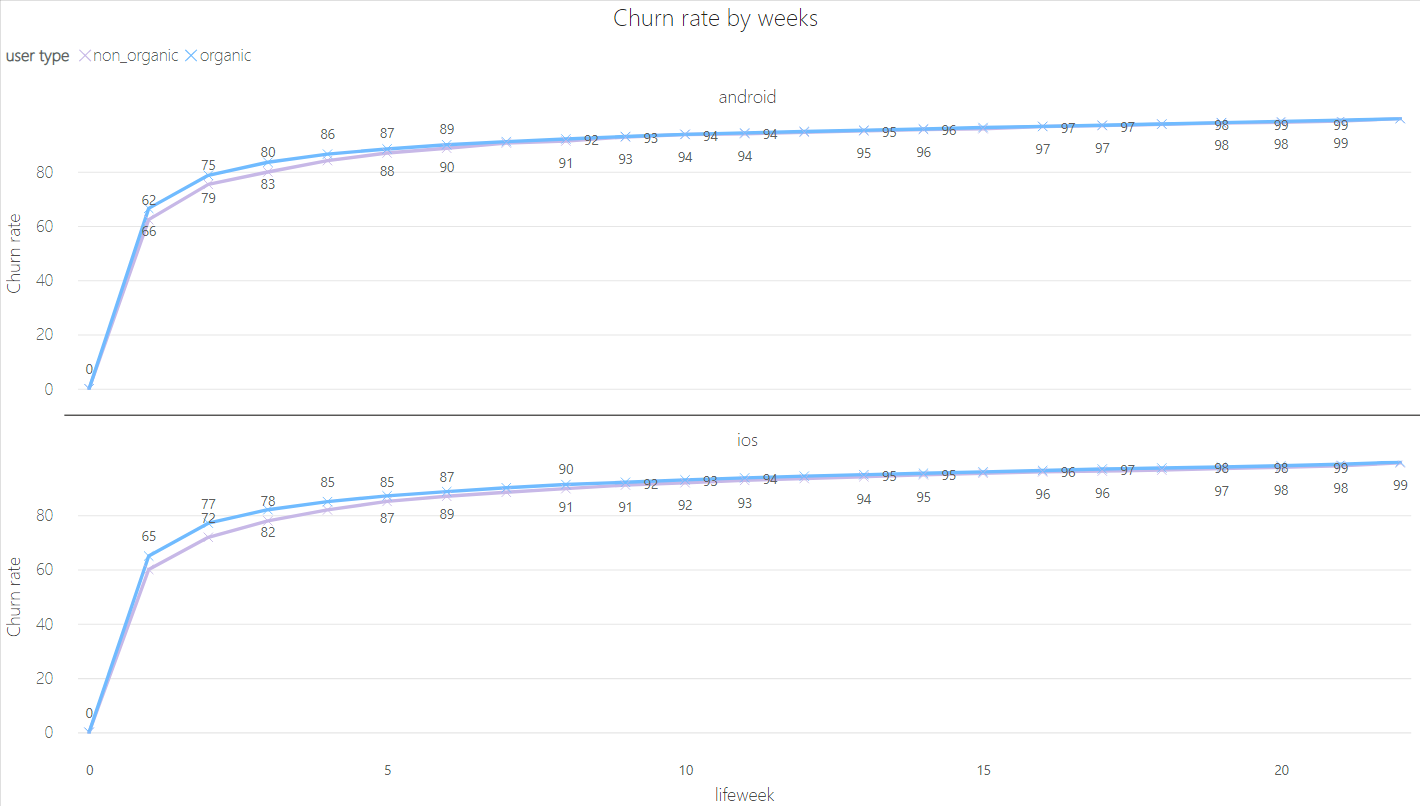

Вывод:
    
    Наибольший отток пользователей во всех когортах наблюдается в первую неделю жизни пользователей в проекте. На платформе android отток чуть меньше для неорганического трафика, на платформе ios - для органического. Линия начинается стремиться к 100 примерно на 7,5 неделе во всех когортах. Проводить анализ в разрезе 2 параметров (трафик, платформа) достаточно сложно, если брать за период недели, но тем не менее небольшие отличия можно все таки заметить.